<a href="https://colab.research.google.com/github/Koussailakadi/Speech_Input_for_Emotion_Recognition/blob/main/Emotion_recognition_from_acoustique_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio


import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Model, Sequential
from keras.layers import Dense, Conv1D, Conv2D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Activation , Add , Input, TimeDistributed, GlobalAveragePooling1D
from keras.callbacks import ModelCheckpoint
from keras import activations

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [12]:
from keras.mixed_precision.device_compatibility_check import log_device_compatibility_check
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs,shuffle=False, batch_size=32):
        'Initialization'
        self.list_IDs = list_IDs
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.len_max=80000
        self.n_classes=6
        self.on_epoch_end()
        self.arousal={"SAD":[0,0,1],"ANG":[1,0,0],"DIS":[1,0,0],"FEA":[1,0,0],"HAP":[1,0,0],"NEU":[0,1,0]}
        self.encoding={"SAD":[0,0,0,0,0,1],"ANG":[0,0,0,0,1,0],"DIS":[0,0,0,1,0,0],
                       "FEA":[0,0,1,0,0,0],"HAP":[0,1,0,0,0,0],"NEU":[1,0,0,0,0,0]}
        
                          
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        #print("index: ",index,",X : ",X.shape,",y: ",y.shape)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def get_data (self,data_IDs):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = []
        y = []

        # Generate data
        for i, sample in enumerate(data_IDs):
            
            data, sampling_rate = librosa.load(sample)
            moyenne = data.mean()
            std = data.std()
            data = (data-moyenne) / std
            
            
            # Store sample
            X.append(data)

            # Store class
            y.append(self.encoding[sample.split("_")[-2]])
            
        X=np.array(self.padding(X))
        X=np.expand_dims(X, axis=2)
        y=np.array(y)
        return X, y
    
    
    def padding(self,data):
        return tf.keras.preprocessing.sequence.pad_sequences(data,maxlen=self.len_max, dtype='float', padding='post', truncating='post',value=0.001)

    
    def __data_generation(self, list_IDs_temp):
      
        np.seterr(invalid='ignore')

        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = []
        y = []

        # Generate data
        for i, sample in enumerate(list_IDs_temp):
            
            data, sampling_rate = librosa.load(sample)

            if len(data)>80000:
                data=data[0:50000]
               
            data=np.array(data)
            moyenne = np.mean(data)
            std = np.std(data)
            data = (data-moyenne) / std

            data=np.array(data)
            data_sum = np.sum(data)
            isnan_data=np.isnan(data_sum)
            if isnan_data==True:
              print("data isnan ? :",isnan_data)
              print(data)
              print("sample: ",i," : " ,sample)
              data=np.nan_to_num(data, copy=False).astype(np.float)

            # Store sample
            X.append(data)

            # Store class
            label=np.array(self.arousal[sample.split("_")[-2]])
            label_sum = np.sum(label)
            isnan_label=np.isnan(label_sum)
            if isnan_label==True:
                print("label isnan ? :",isnan_label)



            y.append(label)
            
        X=np.array(self.padding(X))
        X=np.expand_dims(X, axis=2)
        y=np.array(y)

        return X, y

In [13]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Paths for data.
#load data:
from zipfile import ZipFile
!unzip "/content/drive/MyDrive/AudioWav/AudioWAV.zip" -d AudioWav  

In [15]:
Crema ="/content/AudioWav/"

crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []


for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        print(file)
    

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
df = pd.concat([emotion_df, path_df], axis=1)

# save: 
df.to_csv("data_path.csv",index=False)

print(df.shape)
# delete a this corrupt file: 
corrupt="/content/AudioWav/1076_MTI_SAD_XX.wav"
df = df.drop(df[df.Path==corrupt].index)
print(df.shape)
df.head()

(7442, 2)
(7441, 2)


,Emotions,Path
0,happy,/content/AudioWav/1005_TSI_HAP_XX.wav
1,angry,/content/AudioWav/1024_IEO_ANG_HI.wav
2,neutral,/content/AudioWav/1084_MTI_NEU_XX.wav
3,disgust,/content/AudioWav/1063_IEO_DIS_LO.wav
4,sad,/content/AudioWav/1044_IEO_SAD_LO.wav


In [16]:
# Datasets
# 80 % train data, 20% validation data:
train_data=df.Path[0:6400].to_list()
validation=df.Path[6400:-17].to_list()

partition ={"train":train_data,"validation":validation} # IDs

# Generators
training_generator = DataGenerator(partition['train'])
validation_generator = DataGenerator(partition['validation'])

In [17]:
print(len(train_data))
print(len(validation))

6400
1024


In [18]:
# model: 

#Résidual bloc:
def block(inputs, filters, kernel_size, strides):
    #apply conv1D:
    fx = Conv1D(filters, kernel_size, strides , padding='same')(inputs)

    #apply a batchnormalization to an input tensor:
    fx = BatchNormalization()(fx)
    
    #apply a rulu functgion to batch normalized tensor
    fx = Activation(activations.relu)(fx)
     
    return fx


#Résidual blocs:
def resnet_block(inputs, filters, kernel_size=3, stride=3):
    #bloc 1:
    fx = block(inputs, filters, kernel_size, strides=stride)
    
    #bloc 2:
    fx = block(fx, filters, kernel_size, strides=1)
    
    #bloc 3:
    fx = block(fx, filters, kernel_size, strides=1)
    
    #skip connection:
    skip_x = Conv1D(filters, kernel_size, strides=stride , padding ='same')(inputs)

    #apply a batchnormalization to an input tensor:
    skip_x = BatchNormalization()(skip_x)
    
    #add layer:
    out= Add()([fx,skip_x])
    
    #relu:
    out = Activation(activations.relu)(out)
        
    return out



def Resnet(input_shape=(80000,1)):
    
    x_input=Input(shape=input_shape)
    #stag 1:
    x=Conv1D(filters=128, kernel_size=3, strides=3)(x_input)
    x=BatchNormalization()(x)
    x=Activation(activations.relu)(x)

    #resnets blocs:
    x=resnet_block(x, filters=128, kernel_size=3, stride=3)
    x=resnet_block(x, filters=256, kernel_size=3, stride=3)
    x=resnet_block(x, filters=256, kernel_size=3, stride=3)
    x=resnet_block(x, filters=256, kernel_size=3, stride=3)
    x=resnet_block(x, filters=512, kernel_size=3, stride=3)
    x=resnet_block(x, filters=512, kernel_size=3, stride=3)
    x=resnet_block(x, filters=512, kernel_size=3, stride=3)
    
    #conv2:
    x=Conv1D(filters=768, kernel_size=3, strides=1)(x)
    x=BatchNormalization()(x)
    x=Activation(activations.relu)(x)
    
    #dense layers: 
    """x=Dropout(rate=0.5, noise_shape=None)(x)
    dense_layer=Dense(32,activation=activations.relu)
    x=TimeDistributed(dense_layer)(x)
    dense_layer=Dense(6)
    x=TimeDistributed(dense_layer)(x)
    x=GlobalAveragePooling1D(keepdims=False)(x)
    x=Activation(activations.softmax)(x)"""
    
    x=Flatten()(x)
    x=Dropout(rate=0.5, noise_shape=None)(x)
    x=Dense(32,activation=activations.relu)(x)
    x=Dense(3,activation=activations.softmax)(x)

    #model
    model= Model(x_input, x, name='Rasnet')
    
    return model
  
#inputs:

model=Resnet()


# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

model.summary()

Model: "Rasnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80000, 1)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 26666, 128)   512         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 26666, 128)  512         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 26666, 128)   0           ['batch_normalization[0][0]'

In [63]:
#Train model on dataset
"""rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=1)"""

rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(training_generator, batch_size=32, epochs=10, validation_data=validation_generator)

Epoch 1/10
200/200 [==============================] - 747s 4s/step - loss: 0.7765 - accuracy: 0.6933 - val_loss: 0.9812 - val_accuracy: 0.5303
Epoch 2/10
200/200 [==============================] - 719s 4s/step - loss: 0.6577 - accuracy: 0.6998 - val_loss: 0.9023 - val_accuracy: 0.5879
Epoch 3/10
200/200 [==============================] - 714s 4s/step - loss: 0.6361 - accuracy: 0.7148 - val_loss: 0.8731 - val_accuracy: 0.6787
Epoch 4/10
200/200 [==============================] - 730s 4s/step - loss: 0.6296 - accuracy: 0.7080 - val_loss: 0.8732 - val_accuracy: 0.6934
Epoch 5/10
200/200 [==============================] - 714s 4s/step - loss: 0.6145 - accuracy: 0.7084 - val_loss: 0.9534 - val_accuracy: 0.6475
Epoch 6/10
200/200 [==============================] - 708s 4s/step - loss: 0.6034 - accuracy: 0.7231 - val_loss: 0.7235 - val_accuracy: 0.6826
Epoch 7/10
200/200 [==============================] - 724s 4s/step - loss: 0.5925 - accuracy: 0.7130 - val_loss: 0.7245 - val_accuracy: 0.6973

In [64]:
model.save('/content/drive/MyDrive/resnet_arousal_model.h5')  # creates a HDF5 file 'my_model.h5'

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


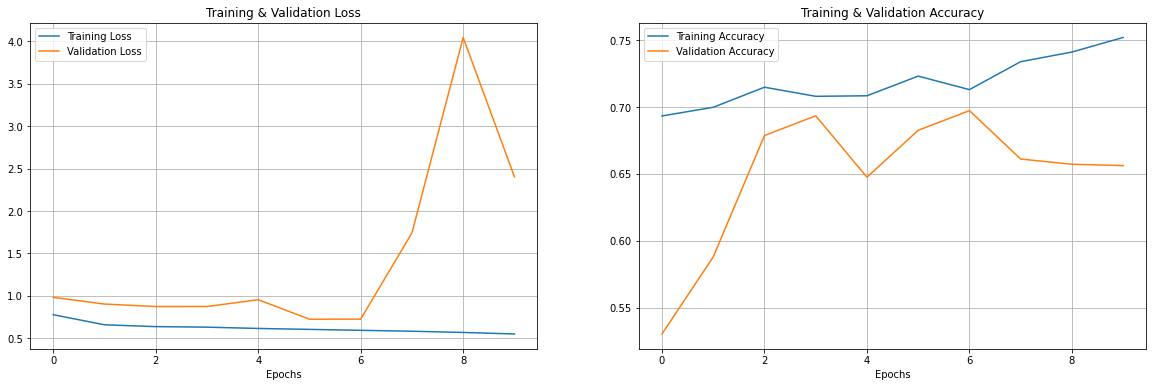

In [10]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history['accuracy']
train_loss = history['loss']
test_acc = history['val_accuracy']
test_loss = history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].grid()

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].grid()
plt.show()

fig.savefig('Trainig_validation_accuracy.png',dpi=fig.dpi)

In [19]:
# load model:
model.load_weights('/content/drive/MyDrive/resnet_arousal_model.h5')

In [50]:
# prédire sur un batch
data_generator_test=DataGenerator(df.Path[0:320].to_list())

In [51]:
# predicting on test data.
pred_test = model.predict(data_generator_test)

In [52]:
res=[]
decod={0:"high",1:"low",2:"middle"}
arousal={"sad":"low","angry":"high","disgust":"high","fear":"high","happy":"high","neutral":"middle"}

print(pred_test)
for pred in pred_test:
  res.append(np.argmax(np.array(pred)))

print(res)
predection_label=[]
for pred in res:
  predection_label.append(decod[pred])

ground_truth=[]
for emotion in df.Emotions[0:320].to_list():
  ground_truth.append(arousal[emotion])

result={"predection_label":predection_label,"ground_truth":ground_truth}
df_result=pd.DataFrame.from_dict(result)
df_result

[[9.99997258e-01 1.15590080e-14 2.72988382e-06]
 [9.99996424e-01 1.47317464e-10 3.55945872e-06]
 [9.93237376e-01 1.08034164e-03 5.68227470e-03]
 [9.98908997e-01 1.26989308e-08 1.09103369e-03]
 [8.63529503e-01 9.13357921e-03 1.27336845e-01]
 [9.99997497e-01 3.54608076e-09 2.52473046e-06]
 [9.97098327e-01 4.21004565e-09 2.90170754e-03]
 [1.00000000e+00 1.80122031e-12 5.99050454e-09]
 [9.89443183e-01 3.12967607e-08 1.05568934e-02]
 [9.99997616e-01 1.45411352e-12 2.41835937e-06]
 [5.09030223e-01 2.38222241e-01 2.52747625e-01]
 [9.71408606e-01 3.59415193e-03 2.49972474e-02]
 [9.98808503e-01 2.51935939e-09 1.19151373e-03]
 [7.37422526e-01 2.39194274e-01 2.33832877e-02]
 [9.99653816e-01 2.48007694e-08 3.46213346e-04]
 [9.99999762e-01 5.96468430e-11 2.14710838e-07]
 [9.83896375e-01 1.20238269e-07 1.61034856e-02]
 [9.96479928e-01 1.74117702e-07 3.52002284e-03]
 [9.99998569e-01 3.38477857e-11 1.43560032e-06]
 [9.99731719e-01 1.28604249e-09 2.68264062e-04]
 [9.99993324e-01 1.82039141e-11 6.665874

,predection_label,ground_truth
0,high,high
1,high,high
2,high,middle
3,high,high
4,high,low
...,...,...
315,high,high
316,high,high
317,high,high
318,high,high


0


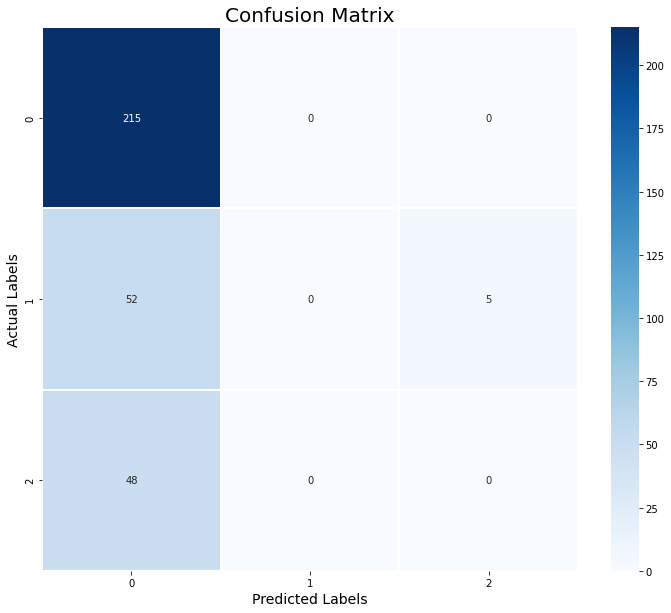

In [60]:
cm = confusion_matrix(ground_truth, predection_label)
print(pred)
fig , ax = plt.subplots(1,1,figsize = (12, 10))
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
ax.set_title('Confusion Matrix', size=20)
ax.set_xlabel('Predicted Labels', size=14)
ax.set_ylabel('Actual Labels', size=14)
plt.savefig("confusion_matrix.png",dpi=fig.dpi)
plt.show()